# data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import tensorflow as tf
color_pal = sns.color_palette()

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.initializers import GlorotUniform

In [2]:
def get_df(MeterCategory):

    df = pd.read_csv("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/anonymized_costs.csv")

    undesired_meter_categories = ['Storage', 'Virtual Machines', 'Automation', 'Bandwidth', 'Load Balancer', 'Log Analytics', 'Service Bus', 'Logic Apps'] 

    # Define the MeterCategories you want to select as a list
    desired_meter_categories = [MeterCategory]  # Add your desired categories

    # Select rows where 'MeterCategory' matches the desired names
    if (MeterCategory == 'Others'):
        df = df[-df['MeterCategory'].isin(undesired_meter_categories)]
    else:
        df = df[df['MeterCategory'].isin(desired_meter_categories)]

    # Rest of your data processing code
    columns_to_eliminate = ['InvoiceSectionName', 'MeterCategory', 'MeterSubCategory', 'MeterName', 'SubscriptionName', 'ResourceGroup', 'ConsumedService', 'ResourceLocation', 'ResourceName']

    # Mapping categorical features (if needed)

    df.drop(columns=columns_to_eliminate, inplace=True)
    df = df.set_index("Date")
    df.index = pd.to_datetime(df.index)

    df['DayOfWeek'] = df.index.day_of_week
    df['Month'] = df.index.month

    df['CostInBillingCurrency'] = df.groupby(df.index.date)['CostInBillingCurrency'].sum()
    df = df.drop_duplicates(subset=['CostInBillingCurrency'])
    df = df.sort_index()
    return df

In [3]:
df = pd.read_csv("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/anonymized_costs.csv")

# Define the MeterCategories you want to select as a list
#desired_meter_categories = ['Storage', 'Virtual Machines', 'Automation', 'Bandwidth', 'Load Balancer', 'Log Analytics', 'Service Bus', 'Logic Apps']  # Add your desired categories

# Select rows where 'MeterCategory' matches the desired names
#df = df[df['MeterCategory'].isin(desired_meter_categories)]

# Rest of your data processing code
columns_to_eliminate = ['InvoiceSectionName', 'MeterCategory', 'MeterSubCategory', 'MeterName', 'SubscriptionName', 'ResourceGroup', 'ConsumedService', 'ResourceLocation', 'ResourceName']

# Mapping categorical features (if needed)

df.drop(columns=columns_to_eliminate, inplace=True)
df = df.set_index("Date")
df.index = pd.to_datetime(df.index)

df['DayOfWeek'] = df.index.day_of_week
df['Month'] = df.index.month

df['CostInBillingCurrency'] = df.groupby(df.index.date)['CostInBillingCurrency'].sum()
df = df.drop_duplicates(subset=['CostInBillingCurrency'])
df = df.sort_index()

Y = df['CostInBillingCurrency'][4:].values

walk_train_y = []
walk_val_y = []
walk_test_y = []

for i in range (5):

    delay = i*5

    walk_train_y.append(Y[delay:50+delay])
    walk_val_y.append(Y[50+delay:60+delay])
    walk_test_y.append(Y[60+delay:65+delay])

In [4]:
def custom_loss(y_true, y_pred):

    rmse_w = 1
    da_w = 1

    # Calculate RMSE
    rmse = K.sqrt(K.mean(K.square(y_pred - y_true)))
    
    # Calculate directional accuracy
    actual_diff = K.sign(y_true[1:] - y_true[:-1])
    pred_diff = K.sign(y_pred[1:] - y_true[:-1])
    num_correct = K.sum(K.cast(K.equal(actual_diff, pred_diff), tf.float32))
    total_comparisons = K.cast(K.shape(y_true)[0] - 1, tf.float32)
    da = num_correct / total_comparisons
    da = 1-da

    # Normalize RMSE and directional accuracy
    rmse_normalized = rmse / (K.max(y_true) - K.min(y_true))
    
    # Combine normalized RMSE and directional accuracy with weights
    loss = (rmse_normalized * rmse_w) + (da * da_w)
    
    return loss

In [5]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

In [6]:
def add_element(data, element):
  DataSet = np.empty((data.shape[0], data.shape[1] + 1))
  for i in range(data.shape[0]):
      nuova_riga = np.append(data[i], element[i])
      DataSet[i] = nuova_riga
  return DataSet

In [7]:
def da(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the sign of the difference between consecutive actual values
    actual_diff = np.sign(y_true[1:] - y_true[:-1])
    
    # Calculate the sign of the difference between the predicted value and the actual value of the previous day
    pred_diff = np.sign(y_pred[1:] - y_true[:-1])
    
    # Calculate the number of times the signs are the same
    num_correct = np.sum(actual_diff == pred_diff)
    
    # Calculate the total number of comparisons (which is one less than the length of the time series)
    total_comparisons = len(y_true) - 1
    
    # Calculate the directional accuracy
    da = num_correct / total_comparisons
    
    return da

In [8]:
def create_train_test_val(df):

    seq_length = 6

    if(len(df) == 89):
        if (seq_length == 4):
            train = 50
        elif (seq_length == 2):
            train = 52
        elif (seq_length == 6):
            train = 48
        val = train+10
        test = train+15
    else:
        train = 50-(85-(len(df)-4))
        if (seq_length == 4):
            train = train
        elif (seq_length == 2):
            train += 2
        elif (seq_length == 6):
            train -= 2

        val = train+10
        test = train+15

    data = df['CostInBillingCurrency'].values
    data = create_sequences(data, seq_length)

    week = df['DayOfWeek'][seq_length:].values
    month = df['Month'][seq_length:].values
    data = data.reshape(len(data), seq_length)

    data = add_element(data, week)
    data = add_element(data, month)

    Y = df['CostInBillingCurrency'][seq_length:].values

    walk_train_x = []
    walk_val_x = []
    walk_test_x = []

    walk_train_y = []
    walk_val_y = []
    walk_test_y = []

    delay = 0


    # divisione dei passi
    for i in range (5):

        delay = i*5

        walk_train_x.append(data[delay:train+delay])
        walk_val_x.append(data[train+delay:val+delay])
        walk_test_x.append(data[val+delay:test+delay])

        walk_train_y.append(Y[delay:train+delay])
        walk_val_y.append(Y[train+delay:val+delay])
        walk_test_y.append(Y[val+delay:test+delay])

    return walk_train_x, walk_train_y, walk_val_x, walk_val_y, walk_test_x, walk_test_y

In [9]:
storage = get_df('Storage')
storage_walk_train_x, storage_walk_train_y, storage_walk_val_x, storage_walk_val_y, storage_walk_test_x, storage_walk_test_y = create_train_test_val(storage)

In [10]:
virtual_machines = get_df('Virtual Machines')
virtual_machines_walk_train_x, virtual_machines_walk_train_y, virtual_machines_walk_val_x, virtual_machines_walk_val_y, virtual_machines_walk_test_x, virtual_machines_walk_test_y = create_train_test_val(virtual_machines)

In [11]:
automation = get_df('Automation')
automation_walk_train_x, automation_walk_train_y, automation_walk_val_x, automation_walk_val_y, automation_walk_test_x, automation_walk_test_y = create_train_test_val(automation)

In [12]:
bandwidth = get_df('Bandwidth')
bandwidth_walk_train_x, bandwidth_walk_train_y, bandwidth_walk_val_x, bandwidth_walk_val_y, bandwidth_walk_test_x, bandwidth_walk_test_y = create_train_test_val(bandwidth)

In [13]:
load_balancer = get_df('Load Balancer')
load_balancer_walk_train_x, load_balancer_walk_train_y, load_balancer_walk_val_x, load_balancer_walk_val_y, load_balancer_walk_test_x, load_balancer_walk_test_y = create_train_test_val(load_balancer)

In [14]:
log_analytics = get_df('Log Analytics')
log_analytics_walk_train_x, log_analytics_walk_train_y, log_analytics_walk_val_x, log_analytics_walk_val_y, log_analytics_walk_test_x, log_analytics_walk_test_y = create_train_test_val(log_analytics)

In [15]:
logic_apps = get_df('Logic Apps')
logic_apps_walk_train_x, logic_apps_walk_train_y, logic_apps_walk_val_x, logic_apps_walk_val_y, logic_apps_walk_test_x, logic_apps_walk_test_y = create_train_test_val(logic_apps)

In [16]:
service_bus = get_df('Service Bus')
service_bus_walk_train_x, service_bus_walk_train_y, service_bus_walk_val_x, service_bus_walk_val_y, service_bus_walk_test_x, service_bus_walk_test_y = create_train_test_val(service_bus)

In [17]:
remaining = get_df('Others')
remaining_walk_train_x, remaining_walk_train_y, remaining_walk_val_x, remaining_walk_val_y, remaining_walk_test_x, remaining_walk_test_y = create_train_test_val(remaining)

# Training

In [18]:
def train_model(model, train_x, train_y, val_x, val_y, cp):
    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs = 25, batch_size = 5, callbacks=[cp], verbose = False)
    model = tf.keras.models.load_model('model', custom_objects={'custom_loss': custom_loss})

    return history.history, model

In [19]:
HISTORY_STORAGE = []
HISTORY_VIRTUAL_MACHINES = []
HISTORY_AUTOMATION = []
HISTORY_LOGIC_APPS = []
HISTORY_BANDWIDTH = []
HISTORY_LOAD_BALANCER = []
HISTORY_LOG_ANALYTICS = []
HISTORY_SERVICE_BUS = []
HISTORY_OTHERS = []

MDA_VAL_STORAGE = []
MDA_VAL_VIRTUAL_MACHINES = []
MDA_VAL_AUTOMATION = []
MDA_VAL_LOGIC_APPS = []
MDA_VAL_BANDWIDTH = []
MDA_VAL_LOAD_BALANCER = []
MDA_VAL_LOG_ANALYTICS = []
MDA_VAL_SERVICE_BUS = []
MDA_VAL_OTHERS = []

MDA_TEST_STORAGE = []
MDA_TEST_VIRTUAL_MACHINES = []
MDA_TEST_AUTOMATION = []
MDA_TEST_LOGIC_APPS = []
MDA_TEST_BANDWIDTH = []
MDA_TEST_LOAD_BALANCER = []
MDA_TEST_LOG_ANALYTICS = []
MDA_TEST_SERVICE_BUS = []
MDA_TEST_OTHERS = []

MODELS_STORAGE = []
MODELS_VIRTUAL_MACHINES = []
MODELS_AUTOMATION = []
MODELS_LOGIC_APPS = []
MODELS_BANDWIDTH = []
MODELS_LOAD_BALANCER = []
MODELS_LOG_ANALYTICS = []
MODELS_SERVICE_BUS = []
MODELS_OTHERS = []

predizioni_test_storage = []
predizioni_test_virtual_machines = []
predizioni_test_automation = []
predizioni_test_bandwidth = []
predizioni_test_logic_apps = []
predizioni_test_log_analytics = []
predizioni_test_load_balancer = []
predizioni_test_service_bus = []
predizioni_test_remaining = []

predizioni_val_storage = []
predizioni_val_virtual_machines = []
predizioni_val_automation = []
predizioni_val_bandwidth = []
predizioni_val_logic_apps = []
predizioni_val_log_analytics = []
predizioni_val_load_balancer = []
predizioni_val_service_bus = []
predizioni_val_remaining = []

In [20]:
# Storage
for i in range(10):

    preds_test = []
    preds_val = []

    walk_history_storage = []

    walk_mda_test = []
    walk_mda_val = []

    history = 0 

    model = Sequential()
    model.add(InputLayer((8, 1)))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))

    model.summary()

    cp = ModelCheckpoint("model/", save_best_only=True, verbose = False)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.01), metrics=[custom_loss])

    storage_model = model

    for i in range(5):  

        history_dict, storage_model = train_model(storage_model, storage_walk_train_x[i], storage_walk_train_y[i], storage_walk_val_x[i], storage_walk_val_y[i], cp)
        walk_history_storage.append(history_dict)
        preds_test.append(storage_model.predict(storage_walk_test_x[i]))
        preds_val.append(storage_model.predict(storage_walk_val_x[i]))

        preds_test = np.array(preds_test)
        preds_val = np.array(preds_val)

        walk_mda_test.append(da(storage_walk_test_y[i],preds_test.reshape(5)))
        walk_mda_val.append(da(storage_walk_val_y[i],preds_val.reshape(10)))

        predizioni_test_storage.append(preds_test)
        predizioni_val_storage.append(preds_val)

        preds_test = []
        preds_val = []
    
    MODELS_STORAGE.append(storage_model)
    MDA_VAL_STORAGE.append(sum(walk_mda_val)/len(walk_mda_val))
    MDA_TEST_STORAGE.append(sum(walk_mda_test)/len(walk_mda_test))
    HISTORY_STORAGE.append(walk_history_storage)

    walk_mda_test = []
    walk_mda_val = []


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 256)            264192    
                                                                 
 lstm_1 (LSTM)               (None, 8, 128)            197120    
                                                                 
 lstm_2 (LSTM)               (None, 8, 64)             49408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 8, 256)            264192    
                                                                 
 lstm_5 (LSTM)               (None, 8, 128)            197120    
                                                                 
 lstm_6 (LSTM)               (None, 8, 64)             49408     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 23ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 8, 256)            264192    
                                                                 
 lstm_9 (LSTM)               (None, 8, 128)            197120    
                                                                 
 lstm_10 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 23ms/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_13 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_14 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_17 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_18 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_19 (LSTM)              (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 31ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_21 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_22 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_23 (LSTM)              (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 39ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 34ms/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_25 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_26 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_27 (LSTM)              (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 29ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 29ms/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_29 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_30 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_31 (LSTM)              (None, 64)                33024     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 24ms/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_33 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_34 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_35 (LSTM)              (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_37 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_38 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_39 (LSTM)              (None, 64)                33024     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 60ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step


In [21]:
HISTORY_VIRTUAL_MACHINES = []
MODELS_VIRTUAL_MACHINES = []
MDA_TEST_VIRTUAL_MACHINES = []
MDA_VAL_VIRTUAL_MACHINES = []

predizioni_test_virtual_machines = []
predizioni_val_virtual_machines = []


# virtual machines
for i in range(5):

    preds_test = []
    preds_val = []

    walk_history_virtual_machines = []

    walk_mda_test = []
    walk_mda_val = []

    history = 0 

    model = Sequential()
    model.add(InputLayer((8, 1)))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))

    model.summary()

    cp = ModelCheckpoint("model/", save_best_only=True, verbose = False)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.01), metrics=[custom_loss])

    virtual_machines_model = model

    for i in range(5):  

        #virtual machines
        history_dict, virtual_machines_model = train_model(virtual_machines_model, virtual_machines_walk_train_x[i], virtual_machines_walk_train_y[i], virtual_machines_walk_val_x[i], virtual_machines_walk_val_y[i], cp)
        walk_history_virtual_machines.append(history_dict)
        preds_test.append(virtual_machines_model.predict(virtual_machines_walk_test_x[i]))
        preds_val.append(virtual_machines_model.predict(virtual_machines_walk_val_x[i]))

        preds_test = np.array(preds_test)
        preds_val = np.array(preds_val)

        walk_mda_test.append(da(virtual_machines_walk_test_y[i],preds_test.reshape(5)))
        walk_mda_val.append(da(virtual_machines_walk_val_y[i],preds_val.reshape(10)))

        predizioni_test_virtual_machines.append(preds_test)
        predizioni_val_virtual_machines.append(preds_val)

        preds_test = []
        preds_val = []
    
    MODELS_VIRTUAL_MACHINES.append(virtual_machines_model)
    MDA_VAL_VIRTUAL_MACHINES.append(sum(walk_mda_val)/len(walk_mda_val))
    MDA_TEST_VIRTUAL_MACHINES.append(sum(walk_mda_test)/len(walk_mda_test))
    HISTORY_VIRTUAL_MACHINES.append(walk_history_virtual_machines)

    walk_mda_test = []
    walk_mda_val = []

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_41 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_42 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_43 (LSTM)              (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [============

In [22]:
# automation
for i in range(5):

    preds_test = []
    preds_val = []

    walk_history_automation = []

    walk_mda_test = []
    walk_mda_val = []

    history = 0 

    model = Sequential()
    model.add(InputLayer((8, 1)))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))

    model.summary()

    cp = ModelCheckpoint("model/", save_best_only=True, verbose = False)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.01), metrics=[custom_loss])

    automation_model = model

    for i in range(5):  

        history_dict, automation_model = train_model(automation_model, automation_walk_train_x[i], automation_walk_train_y[i], automation_walk_val_x[i], automation_walk_val_y[i], cp)
        walk_history_automation.append(history_dict)
        preds_test.append(automation_model.predict(automation_walk_test_x[i]))
        preds_val.append(automation_model.predict(automation_walk_val_x[i]))

        preds_test = np.array(preds_test)
        preds_val = np.array(preds_val)

        walk_mda_test.append(da(automation_walk_test_y[i],preds_test.reshape(5)))
        walk_mda_val.append(da(automation_walk_val_y[i],preds_val.reshape(10)))

        predizioni_test_automation.append(preds_test)
        predizioni_val_automation.append(preds_val)

        preds_test = []
        preds_val = []
    
    MODELS_AUTOMATION.append(automation_model)
    MDA_VAL_AUTOMATION.append(sum(walk_mda_val)/len(walk_mda_val))
    MDA_TEST_AUTOMATION.append(sum(walk_mda_test)/len(walk_mda_test))
    HISTORY_AUTOMATION.append(walk_history_automation)

    walk_mda_test = []
    walk_mda_val = []

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_61 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_62 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_63 (LSTM)              (None, 64)                33024     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:A

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 26ms/step
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_65 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_66 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_67 (LSTM)              (None, 64)                33024     
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_69 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_70 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_71 (LSTM)              (None, 64)                33024     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_73 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_74 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_75 (LSTM)              (None, 64)                33024     
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_77 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_78 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_79 (LSTM)              (None, 64)                33024     
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 24ms/step


In [23]:
# logic apps
for i in range(5):

    preds_test = []
    preds_val = []

    walk_history_logic_apps = []

    walk_mda_test = []
    walk_mda_val = []

    history = 0 

    model = Sequential()
    model.add(InputLayer((8, 1)))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))

    model.summary()

    cp = ModelCheckpoint("model/", save_best_only=True, verbose = False)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.01), metrics=[custom_loss])

    logic_apps_model = model

    for i in range(5):  

        #storage
        history_dict, logic_apps_model = train_model(logic_apps_model, logic_apps_walk_train_x[i], logic_apps_walk_train_y[i], logic_apps_walk_val_x[i], logic_apps_walk_val_y[i], cp)
        walk_history_logic_apps.append(history_dict)
        preds_test.append(logic_apps_model.predict(logic_apps_walk_test_x[i]))
        preds_val.append(logic_apps_model.predict(logic_apps_walk_val_x[i]))

        preds_test = np.array(preds_test)
        preds_val = np.array(preds_val)

        walk_mda_test.append(da(logic_apps_walk_test_y[i],preds_test.reshape(5)))
        walk_mda_val.append(da(logic_apps_walk_val_y[i],preds_val.reshape(10)))

        predizioni_test_logic_apps.append(preds_test)
        predizioni_val_logic_apps.append(preds_val)
        
        preds_test = []
        preds_val = []
    
    MODELS_LOGIC_APPS.append(logic_apps_model)
    MDA_VAL_LOGIC_APPS.append(sum(walk_mda_val)/len(walk_mda_val))
    MDA_TEST_LOGIC_APPS.append(sum(walk_mda_test)/len(walk_mda_test))
    HISTORY_LOGIC_APPS.append(walk_history_logic_apps)

    walk_mda_test = []
    walk_mda_val = []

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_81 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_82 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_83 (LSTM)              (None, 64)                33024     
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:A

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 30ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_85 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_86 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_87 (LSTM)              (None, 64)                33024     
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_89 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_90 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_91 (LSTM)              (None, 64)                33024     
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_92 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_93 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_94 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_95 (LSTM)              (None, 64)                33024     
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 24ms/step
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_97 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_98 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_99 (LSTM)              (None, 64)                33024     
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step


In [24]:
# load balancer
for i in range(5):

    preds_test = []
    preds_val = []

    walk_history_load_balancer = []

    walk_mda_test = []
    walk_mda_val = []

    history = 0 

    model = Sequential()
    model.add(InputLayer((8, 1)))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))

    model.summary()

    cp = ModelCheckpoint("model/", save_best_only=True, verbose = False)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.01), metrics=[custom_loss])

    load_balancer_model = model

    for i in range(5):  

        #load_balancer
        history_dict, load_balancer_model = train_model(load_balancer_model, load_balancer_walk_train_x[i], load_balancer_walk_train_y[i], load_balancer_walk_val_x[i], load_balancer_walk_val_y[i], cp)
        walk_history_load_balancer.append(history_dict)
        preds_test.append(load_balancer_model.predict(load_balancer_walk_test_x[i]))
        preds_val.append(load_balancer_model.predict(load_balancer_walk_val_x[i]))

        preds_test = np.array(preds_test)
        preds_val = np.array(preds_val)

        walk_mda_test.append(da(load_balancer_walk_test_y[i],preds_test.reshape(5)))
        walk_mda_val.append(da(load_balancer_walk_val_y[i],preds_val.reshape(10)))

        predizioni_test_load_balancer.append(preds_test)
        predizioni_val_load_balancer.append(preds_val)

        preds_test = []
        preds_val = []
    
    MODELS_LOAD_BALANCER.append(load_balancer_model)
    MDA_VAL_LOAD_BALANCER.append(sum(walk_mda_val)/len(walk_mda_val))
    MDA_TEST_LOAD_BALANCER.append(sum(walk_mda_test)/len(walk_mda_test))
    HISTORY_LOAD_BALANCER.append(walk_history_load_balancer)

    walk_mda_test = []
    walk_mda_val = []

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_100 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_101 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_102 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_103 (LSTM)             (None, 64)                33024     
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:A

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 23ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 26ms/step
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_104 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_105 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_106 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_107 (LSTM)             (None, 64)                33024     
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 25ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 29ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 29ms/step
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_108 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_109 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_110 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_111 (LSTM)             (None, 64)                33024     
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_112 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_113 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_114 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_115 (LSTM)             (None, 64)                33024     
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 29ms/step
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_116 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_117 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_118 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_119 (LSTM)             (None, 64)                33024     
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step


In [25]:
predizioni_val_log_analytics = []
predizioni_test_log_analytics = []
MODELS_LOG_ANALYTICS = []
MDA_TEST_LOG_ANALYTICS = []
MDA_VAL_LOG_ANALYTICS = []
HISTORY_LOG_ANALYTICS = []

# log analytics
for i in range(5):

    preds_test = []
    preds_val = []

    walk_history_log_analytics = []

    walk_mda_test = []
    walk_mda_val = []

    history = 0 

    model = Sequential()
    model.add(InputLayer((8, 1)))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))

    model.summary()

    cp = ModelCheckpoint("model/", save_best_only=True, verbose = False)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.01), metrics=[custom_loss])

    log_analytics_model = model
    
    for i in range(5):  

        history_dict, log_analytics_model = train_model(log_analytics_model, log_analytics_walk_train_x[i], log_analytics_walk_train_y[i], log_analytics_walk_val_x[i], log_analytics_walk_val_y[i], cp)
        walk_history_log_analytics.append(history_dict)
        preds_test.append(log_analytics_model.predict(log_analytics_walk_test_x[i]))
        preds_val.append(log_analytics_model.predict(log_analytics_walk_val_x[i]))

        preds_test = np.array(preds_test)
        preds_val = np.array(preds_val)

        walk_mda_test.append(da(log_analytics_walk_test_y[i],preds_test.reshape(5)))
        walk_mda_val.append(da(log_analytics_walk_val_y[i],preds_val.reshape(10)))

        predizioni_test_log_analytics.append(preds_test)
        predizioni_val_log_analytics.append(preds_val)

        preds_test = []
        preds_val = []
    
    MODELS_LOG_ANALYTICS.append(log_analytics_model)
    MDA_VAL_LOG_ANALYTICS.append(sum(walk_mda_val)/len(walk_mda_val))
    MDA_TEST_LOG_ANALYTICS.append(sum(walk_mda_test)/len(walk_mda_test))
    HISTORY_LOG_ANALYTICS.append(walk_history_log_analytics)

    walk_mda_test = []
    walk_mda_val = []

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_120 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_121 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_122 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_123 (LSTM)             (None, 64)                33024     
                                                                 
 dense_30 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:A

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 23ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 19ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_124 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_125 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_126 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_127 (LSTM)             (None, 64)                33024     
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 23ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_128 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_129 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_130 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_131 (LSTM)             (None, 64)                33024     
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 27ms/step
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_132 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_133 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_134 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_135 (LSTM)             (None, 64)                33024     
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 24ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 25ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_136 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_137 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_138 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_139 (LSTM)             (None, 64)                33024     
                                                                 
 dense_34 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 25ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 27ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 25ms/step


In [26]:
# bandwidth
for i in range(5):

    preds_test = []
    preds_val = []

    walk_history_bandwidth = []

    walk_mda_test = []
    walk_mda_val = []

    history = 0 

    model = Sequential()
    model.add(InputLayer((8, 1)))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))

    model.summary()

    cp = ModelCheckpoint("model/", save_best_only=True, verbose = False)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.01), metrics=[custom_loss])

    bandwidth_model = model

    for i in range(5):  

        #storage
        history_dict, bandwidth_model = train_model(bandwidth_model, bandwidth_walk_train_x[i], bandwidth_walk_train_y[i], bandwidth_walk_val_x[i], bandwidth_walk_val_y[i], cp)
        walk_history_bandwidth.append(history_dict)
        preds_test.append(bandwidth_model.predict(bandwidth_walk_test_x[i]))
        preds_val.append(bandwidth_model.predict(bandwidth_walk_val_x[i]))

        preds_test = np.array(preds_test)
        preds_val = np.array(preds_val)

        walk_mda_test.append(da(bandwidth_walk_test_y[i],preds_test.reshape(5)))
        walk_mda_val.append(da(bandwidth_walk_val_y[i],preds_val.reshape(10)))

        predizioni_test_bandwidth.append(preds_test)
        predizioni_val_bandwidth.append(preds_val)

        preds_test = []
        preds_val = []
    
    MODELS_BANDWIDTH.append(bandwidth_model)
    MDA_VAL_BANDWIDTH.append(sum(walk_mda_val)/len(walk_mda_val))
    MDA_TEST_BANDWIDTH.append(sum(walk_mda_test)/len(walk_mda_test))
    HISTORY_BANDWIDTH.append(walk_history_bandwidth)

    walk_mda_test = []
    walk_mda_val = []

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_140 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_141 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_142 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_143 (LSTM)             (None, 64)                33024     
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:A

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_144 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_145 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_146 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_147 (LSTM)             (None, 64)                33024     
                                                                 
 dense_36 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 19ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_148 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_149 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_150 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_151 (LSTM)             (None, 64)                33024     
                                                                 
 dense_37 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_152 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_153 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_154 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_155 (LSTM)             (None, 64)                33024     
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_156 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_157 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_158 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_159 (LSTM)             (None, 64)                33024     
                                                                 
 dense_39 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 36ms/step


In [27]:
# service bus
for i in range(5):

    preds_test = []
    preds_val = []

    walk_history_service_bus = []

    walk_mda_test = []
    walk_mda_val = []

    history = 0 

    model = Sequential()
    model.add(InputLayer((8, 1)))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))

    model.summary()

    cp = ModelCheckpoint("model/", save_best_only=True, verbose = False)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.01), metrics=[custom_loss])

    service_bus_model = model

    for i in range(5):  

        history_dict, service_bus_model = train_model(service_bus_model, service_bus_walk_train_x[i], service_bus_walk_train_y[i], service_bus_walk_val_x[i], service_bus_walk_val_y[i], cp)
        walk_history_service_bus.append(history_dict)
        preds_test.append(service_bus_model.predict(service_bus_walk_test_x[i]))
        preds_val.append(service_bus_model.predict(service_bus_walk_val_x[i]))

        preds_test = np.array(preds_test)
        preds_val = np.array(preds_val)

        walk_mda_test.append(da(service_bus_walk_test_y[i],preds_test.reshape(5)))
        walk_mda_val.append(da(service_bus_walk_val_y[i],preds_val.reshape(10)))

        predizioni_test_service_bus.append(preds_test)
        predizioni_val_service_bus.append(preds_val)

        preds_test = []
        preds_val = []
    
    MODELS_SERVICE_BUS.append(service_bus_model)
    MDA_VAL_SERVICE_BUS.append(sum(walk_mda_val)/len(walk_mda_val))
    MDA_TEST_SERVICE_BUS.append(sum(walk_mda_test)/len(walk_mda_test))
    HISTORY_SERVICE_BUS.append(walk_history_service_bus)

    walk_mda_test = []
    walk_mda_val = []


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_160 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_161 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_162 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_163 (LSTM)             (None, 64)                33024     
                                                                 
 dense_40 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:A

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_164 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_165 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_166 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_167 (LSTM)             (None, 64)                33024     
                                                                 
 dense_41 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_168 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_169 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_170 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_171 (LSTM)             (None, 64)                33024     
                                                                 
 dense_42 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 27ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 32ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 47ms/step
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_172 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_173 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_174 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_175 (LSTM)             (None, 64)                33024     
                                                                 
 dense_43 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 25ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 31ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 35ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_176 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_177 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_178 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_179 (LSTM)             (None, 64)                33024     
                                                                 
 dense_44 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 39ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 49ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 30ms/step


In [29]:
predizioni_val_remaining = []
predizioni_test_remaining = []
MODELS_OTHERS = []
MDA_TEST_OTHERS = []
MDA_VAL_OTHERS = []
HISTORY_OTHERS = []

#remaining
for i in range(10):

    preds_test = []
    preds_val = []

    walk_history_remaining = []

    walk_mda_test = []
    walk_mda_val = []

    history = 0 

    model = Sequential()
    model.add(InputLayer((8, 1)))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))

    model.summary()

    cp = ModelCheckpoint("model/", save_best_only=True, verbose = False)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.01), metrics=[custom_loss])

    remaining_model = model
    for i in range(5):  

        #storage
        history_dict, remaining_model = train_model(remaining_model, remaining_walk_train_x[i], remaining_walk_train_y[i], remaining_walk_val_x[i], remaining_walk_val_y[i], cp)
        walk_history_remaining.append(history_dict)
        preds_test.append(remaining_model.predict(remaining_walk_test_x[i]))
        preds_val.append(remaining_model.predict(remaining_walk_val_x[i]))

        preds_test = np.array(preds_test)
        preds_val = np.array(preds_val)

        walk_mda_test.append(da(remaining_walk_test_y[i],preds_test.reshape(5)))
        walk_mda_val.append(da(remaining_walk_val_y[i],preds_val.reshape(10)))

        predizioni_test_remaining.append(preds_test)
        predizioni_val_remaining.append(preds_val)

        preds_test = []
        preds_val = []
    
    MODELS_OTHERS.append(remaining_model)
    MDA_VAL_OTHERS.append(sum(walk_mda_val)/len(walk_mda_val))
    MDA_TEST_OTHERS.append(sum(walk_mda_test)/len(walk_mda_test))
    HISTORY_OTHERS.append(walk_history_remaining)

    walk_mda_test = []
    walk_mda_val = []

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_180 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_181 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_182 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_183 (LSTM)             (None, 64)                33024     
                                                                 
 dense_45 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:A

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 16ms/step
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_184 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_185 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_186 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_187 (LSTM)             (None, 64)                33024     
                                                                 
 dense_46 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 23ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 25ms/step
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_188 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_189 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_190 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_191 (LSTM)             (None, 64)                33024     
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 19ms/step
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_192 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_193 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_194 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_195 (LSTM)             (None, 64)                33024     
                                                                 
 dense_48 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 15ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 15ms/step
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_196 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_197 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_198 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_199 (LSTM)             (None, 64)                33024     
                                                                 
 dense_49 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 19ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 17ms/step
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_200 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_201 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_202 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_203 (LSTM)             (None, 64)                33024     
                                                                 
 dense_50 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 18ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 15ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 15ms/step
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_204 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_205 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_206 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_207 (LSTM)             (None, 64)                33024     
                                                                 
 dense_51 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 18ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_208 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_209 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_210 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_211 (LSTM)             (None, 64)                33024     
                                                                 
 dense_52 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 23ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_212 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_213 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_214 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_215 (LSTM)             (None, 64)                33024     
                                                                 
 dense_53 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 15ms/step
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_216 (LSTM)             (None, 8, 256)            264192    
                                                                 
 lstm_217 (LSTM)             (None, 8, 128)            197120    
                                                                 
 lstm_218 (LSTM)             (None, 8, 64)             49408     
                                                                 
 lstm_219 (LSTM)             (None, 64)                33024     
                                                                 
 dense_54 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 27ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 18ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 15ms/step


# Results

In [39]:
print(MDA_VAL_STORAGE)
print(MDA_VAL_VIRTUAL_MACHINES)
print(MDA_VAL_AUTOMATION)
print(MDA_VAL_LOGIC_APPS)
print(MDA_VAL_BANDWIDTH)
print(MDA_VAL_LOAD_BALANCER)
print(MDA_VAL_LOG_ANALYTICS)
print(MDA_VAL_SERVICE_BUS)
print(MDA_VAL_OTHERS)

print(MDA_TEST_STORAGE[7])
print(MDA_TEST_VIRTUAL_MACHINES[0])
print(MDA_TEST_AUTOMATION[0])
print(MDA_TEST_LOGIC_APPS[3])
print(MDA_TEST_BANDWIDTH[2])
print(MDA_TEST_LOAD_BALANCER[4])
print(MDA_TEST_LOG_ANALYTICS[4])
print(MDA_TEST_SERVICE_BUS[4])
print(MDA_TEST_OTHERS[6])

storage_int = 7
virtual_machines_int = 0
automation_int = 0
logic_apps_int = 3
bandwidth_int = 2
load_balancer_int = 4
log_analytics_int = 4
service_bus_int = 4
remaining_int = 6

[0.5333333333333334, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.6444444444444445, 0.5555555555555556, 0.5555555555555556]
[0.5111111111111111, 0.5111111111111111, 0.5111111111111111, 0.5111111111111111, 0.5111111111111111]
[0.6666666666666667, 0.6222222222222221, 0.6666666666666667, 0.6, 0.6666666666666667]
[0.39999999999999997, 0.48888888888888893, 0.6444444444444445, 0.6888888888888889, 0.6666666666666666]
[0.6666666666666667, 0.6666666666666667, 0.7333333333333333, 0.6444444444444444, 0.7333333333333333]
[0.5555555555555556, 0.6, 0.5777777777777777, 0.6, 0.6222222222222222]
[0.6888888888888889, 0.7333333333333333, 0.7333333333333333, 0.711111111111111, 0.7999999999999999]
[0.6444444444444445, 0.6222222222222221, 0.6888888888888889, 0.6666666666666666, 0.7555555555555555]
[0.6, 0.5555555555555556, 0.6222222222222223, 0.6222222222222222, 0.5777777777777778, 0.7333333333333334, 0.7555555555555555, 0.71111111

In [40]:
model_storage = MODELS_STORAGE[storage_int]
model_virtual_machines = MODELS_VIRTUAL_MACHINES[virtual_machines_int]
model_automation = MODELS_AUTOMATION[automation_int]
model_logic_apps = MODELS_LOGIC_APPS[logic_apps_int]
model_log_analytics = MODELS_LOG_ANALYTICS[log_analytics_int]
model_bandwidth = MODELS_BANDWIDTH[bandwidth_int]
model_load_balancer = MODELS_LOAD_BALANCER[load_balancer_int]
model_service_bus = MODELS_SERVICE_BUS[service_bus_int]
model_remaining = MODELS_OTHERS[remaining_int]

In [49]:
model_storage.save("Models_6_step/model_storage_6_step")
model_virtual_machines.save("Models_6_step/model_virtual_machines_6_step")
model_automation.save("Models_6_step/model_automation_6_step")
model_logic_apps.save("Models_6_step/model_logic_apps_6_step")
model_log_analytics.save("Models_6_step/model_log_analytics_6_step") 
model_bandwidth.save("Models_6_step/model_bandwidth_6_step")
model_load_balancer.save("Models_6_step/model_load_balancer_6_step")
model_service_bus.save("Models_6_step/model_service_bus_6_step") 
model_remaining.save("Models_6_step/model_remaining_6_step")

INFO:tensorflow:Assets written to: Models_6_step/model_storage_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_storage_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_virtual_machines_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_virtual_machines_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_automation_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_automation_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_logic_apps_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_logic_apps_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_log_analytics_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_log_analytics_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_bandwidth_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_bandwidth_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_load_balancer_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_load_balancer_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_service_bus_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_service_bus_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_remaining_6_step/assets


INFO:tensorflow:Assets written to: Models_6_step/model_remaining_6_step/assets


In [41]:
def reshape_predictions(predictions_list):
    predictions_list = np.array(predictions_list)
    predictions_list = predictions_list.reshape(len(predictions_list)//5,25)
    return predictions_list

50

In [42]:
predizioni_test_storage = reshape_predictions(predizioni_test_storage)
predizioni_test_automation = reshape_predictions(predizioni_test_automation)
predizioni_test_virtual_machines = reshape_predictions(predizioni_test_virtual_machines)
predizioni_test_bandwidth = reshape_predictions(predizioni_test_bandwidth)
predizioni_test_load_balancer = reshape_predictions(predizioni_test_load_balancer)
predizioni_test_log_analytics = reshape_predictions(predizioni_test_log_analytics)
predizioni_test_logic_apps = reshape_predictions(predizioni_test_logic_apps)
predizioni_test_service_bus = reshape_predictions(predizioni_test_service_bus)
predizioni_test_remaining = reshape_predictions(predizioni_test_remaining)

In [43]:
SUM_DF = pd.DataFrame()
SUM_DF['ground_truth'] = df['CostInBillingCurrency'][-26:]
SUM_DF['storage'] = 0
SUM_DF['virtual_machines'] = 0
SUM_DF['automation'] = 0
SUM_DF['logic_apps'] = 0
SUM_DF['log_analytics'] = 0
SUM_DF['bandwidth'] = 0
SUM_DF['load_balancer'] = 0
SUM_DF['service_bus'] = 0
SUM_DF['Others'] = 0

In [44]:
def insert_firtst_day(p, DF):
    p = np.array(p)
    p = np.insert(p, 0, DF['ground_truth'][0])  

    return p


In [45]:
df_storage = insert_firtst_day(predizioni_test_storage[storage_int],SUM_DF) 
df_virtual_machines = insert_firtst_day(predizioni_test_virtual_machines[virtual_machines_int],SUM_DF) 
df_automation = insert_firtst_day(predizioni_test_automation[automation_int],SUM_DF) 
df_logic_apps = insert_firtst_day(predizioni_test_logic_apps[logic_apps_int],SUM_DF) 
df_log_analytics = insert_firtst_day(predizioni_test_log_analytics[log_analytics_int],SUM_DF) 
df_bandwodth = insert_firtst_day(predizioni_test_bandwidth[bandwidth_int],SUM_DF) 
df_load_balancer = insert_firtst_day(predizioni_test_load_balancer[load_balancer_int],SUM_DF) 
df_service_bus = insert_firtst_day(predizioni_test_service_bus[service_bus_int],SUM_DF) 
df_remaining = insert_firtst_day(predizioni_test_remaining[remaining_int],SUM_DF) 

SUM_DF['storage'] = df_storage
SUM_DF['virtual_machines'] = df_virtual_machines
SUM_DF['automation'] = df_automation
SUM_DF['logic_apps'] = df_logic_apps
SUM_DF['log_analytics'] = df_log_analytics
SUM_DF['bandwidth'] = df_bandwodth
SUM_DF['load_balancer'] = df_load_balancer
SUM_DF['service_bus'] = df_service_bus
SUM_DF['Others'] = df_remaining

In [50]:
SUM_DF

,storage,virtual_machines,automation,logic_apps,log_analytics,bandwidth,load_balancer,service_bus,Others,SUM,ground_truth
Date,,,,,,,,,,,
2023-02-23,110.306381,110.306381,110.306381,110.306381,110.306381,110.306381,110.306381,110.306381,110.306381,992.757507,110.306381
2023-02-24,21.629164,17.816616,0.009914,1.919490,0.431589,0.039494,4.670322,0.132162,61.334953,107.983704,108.557959
2023-02-25,21.624479,17.819107,0.009901,1.098380,0.431634,0.039528,4.703234,0.132099,59.690910,105.549271,107.925850
2023-02-26,21.626253,17.819199,0.009896,0.613522,0.431609,0.039562,4.733448,0.132085,58.202896,103.608467,103.073215
2023-02-27,21.674078,17.818508,0.009978,0.433257,0.430869,0.039415,4.721598,0.132278,57.031921,102.291901,110.290543
2023-02-28,21.695795,17.817055,0.009968,0.444688,0.430903,0.039417,4.696507,0.132317,56.358414,101.625061,102.686326
2023-03-01,21.648504,17.814726,0.009941,0.462555,0.192908,0.039443,4.839612,0.031554,56.408615,101.447861,81.475006
2023-03-02,21.576899,17.812469,0.009928,0.477205,0.192913,0.039472,4.838470,0.009158,56.008148,100.964661,78.840089
2023-03-03,21.547625,17.808500,0.009912,0.493747,0.192922,0.039504,4.836792,-0.024299,55.946117,100.850815,93.283237


In [47]:
SUM_DF = SUM_DF.drop('ground_truth', axis=1)
#SUM_DF = SUM_DF.drop('SUM', axis=1)
SUM_DF['SUM'] = SUM_DF.sum(axis=1, skipna=True)
SUM_DF['ground_truth'] = df['CostInBillingCurrency'][-26:]
SUM_DF

,storage,virtual_machines,automation,logic_apps,log_analytics,bandwidth,load_balancer,service_bus,Others,SUM,ground_truth
Date,,,,,,,,,,,
2023-02-23,110.306381,110.306381,110.306381,110.306381,110.306381,110.306381,110.306381,110.306381,110.306381,992.757507,110.306381
2023-02-24,21.629164,17.816616,0.009914,1.919490,0.431589,0.039494,4.670322,0.132162,61.334953,107.983704,108.557959
2023-02-25,21.624479,17.819107,0.009901,1.098380,0.431634,0.039528,4.703234,0.132099,59.690910,105.549271,107.925850
2023-02-26,21.626253,17.819199,0.009896,0.613522,0.431609,0.039562,4.733448,0.132085,58.202896,103.608467,103.073215
2023-02-27,21.674078,17.818508,0.009978,0.433257,0.430869,0.039415,4.721598,0.132278,57.031921,102.291901,110.290543
2023-02-28,21.695795,17.817055,0.009968,0.444688,0.430903,0.039417,4.696507,0.132317,56.358414,101.625061,102.686326
2023-03-01,21.648504,17.814726,0.009941,0.462555,0.192908,0.039443,4.839612,0.031554,56.408615,101.447861,81.475006
2023-03-02,21.576899,17.812469,0.009928,0.477205,0.192913,0.039472,4.838470,0.009158,56.008148,100.964661,78.840089
2023-03-03,21.547625,17.808500,0.009912,0.493747,0.192922,0.039504,4.836792,-0.024299,55.946117,100.850815,93.283237


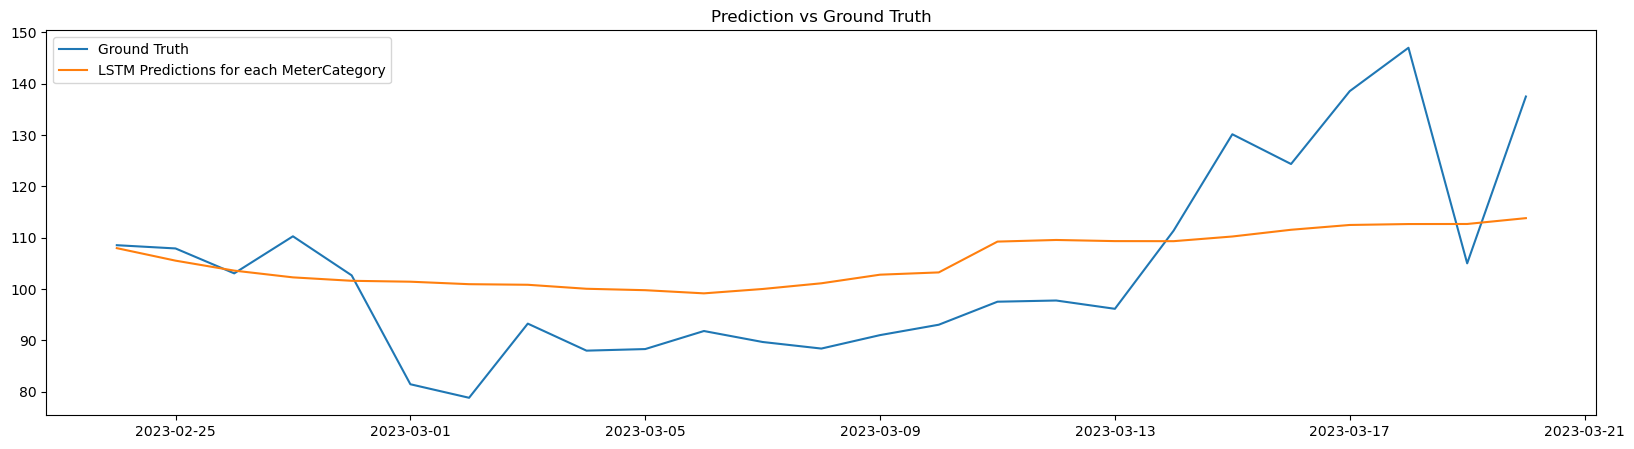

MDA = 0.64
RMSE = 14.630167357324286


In [48]:
pred_data = SUM_DF['SUM']
truth_data = SUM_DF['ground_truth']

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))